## Image Classification on Fashion-MNIST with CNN

* Downloading and exploring the data
* Implementing the CNN
* Understanding CNN architecture
* Creating the CNN model using Keras
* Code explanation
* Analyzing the predictions produced with a CNN

# Downloading and exploring the data #


In [37]:
import matplotlib.pyplot as plt
import numpy as np
# Required for data downaload and preparation
import struct
import gzip
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
from six.moves.urllib.request import urlretrieve


%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [39]:
# Fashion-MNIST consists of images of clothing garments. Our task is to classify each garment into a category (e.g., dress, T-shirt).
# The dataset contains two sets: the training set and the test set. 
# We’ll train on the training set and evaluate the performance of our model on the unseen test dataset. 
# We’ll further split the training set into two sets: training and validation sets. 
# We’ll use the validation dataset as a continuous performance monitoring mechanism for our model. 
# We’ll discuss the details later, but we’ll see that we can reach up to approximately 88% test 
# accuracy without any special regularization or tricks.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [12]:
print("The train_images is shape of {}".format(train_images.shape))
print("The train_labels is shape of {}".format(train_labels.shape))
print("The test_images is shape of {}".format(test_images.shape))
print("The test_labels is shape of {}".format(test_labels.shape))

The train_images is shape of (60000, 28, 28)
The train_labels is shape of (60000,)
The test_images is shape of (10000, 28, 28)
The test_labels is shape of (10000,)


In [40]:
# create variable of class id to class name mapping for explorations and post-training analysis
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
label_map[0]

'T-shirt/top'

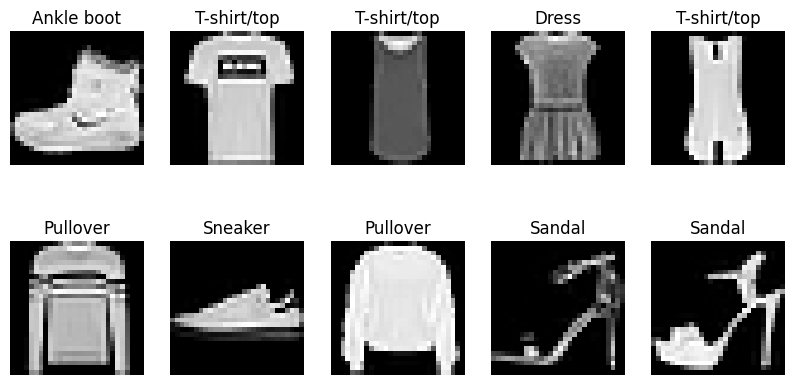

In [41]:
n_rows = 2
n_cols = 5
f, axes = plt.subplots(n_rows, n_cols, figsize=(10,5))

for row in range(len(axes)):
    for col in range(len(axes[row])):

        axes[row][col].imshow(train_images[row*n_cols+col, :, :], cmap=plt.get_cmap('gray'))
        axes[row][col].set_title(label_map[train_labels[row*n_cols+col]])
        axes[row][col].axis('off')

In [29]:
# since images are black and white no point of considering channel dimension
train_images = train_images[:, :, :, None] #batch, height, width, channel dimension
test_images = test_images[:, :, :, None] #batch, height, width, channel dimension

In [31]:
print("The shape of train_images is {}".format(train_images.shape))
print("The shape of test_images is {}".format(test_images.shape))

The shape of train_images is (60000, 28, 28, 1)
The shape of test_images is (10000, 28, 28, 1)


## Implementing the CNN #


In [32]:
# define hyperparameters
batch_size = 100
n_channels = 1 # color channels
n_classes = 10 # number of different digits

# Understanding CNN architecture #
* A convolutional layer with a 5 × 5 kernel, 1 × 1 stride, and valid padding.

* A max pooling layer with a 2 × 2 kernel, 2 × 2 stride, and valid pooling.

* A convolutional layer with a 5 × 5 kernel, 1 × 1 stride, and valid pooling.

* A max pooling layer with a 2 × 2 kernel, 2 × 2 stride, and valid pooling.

* A convolutional layer with a 4 × 4 kernel, 1 × 1 stride, and valid pooling.

* A layer that flattens the 2D output to a 1D vector.

* A Dense layer with 84 nodes.

* All the layers except the last have rectified linear unit (ReLU) activation

* A final softmax prediction layer with 10 nodes.

# Creating the CNN model using Keras #
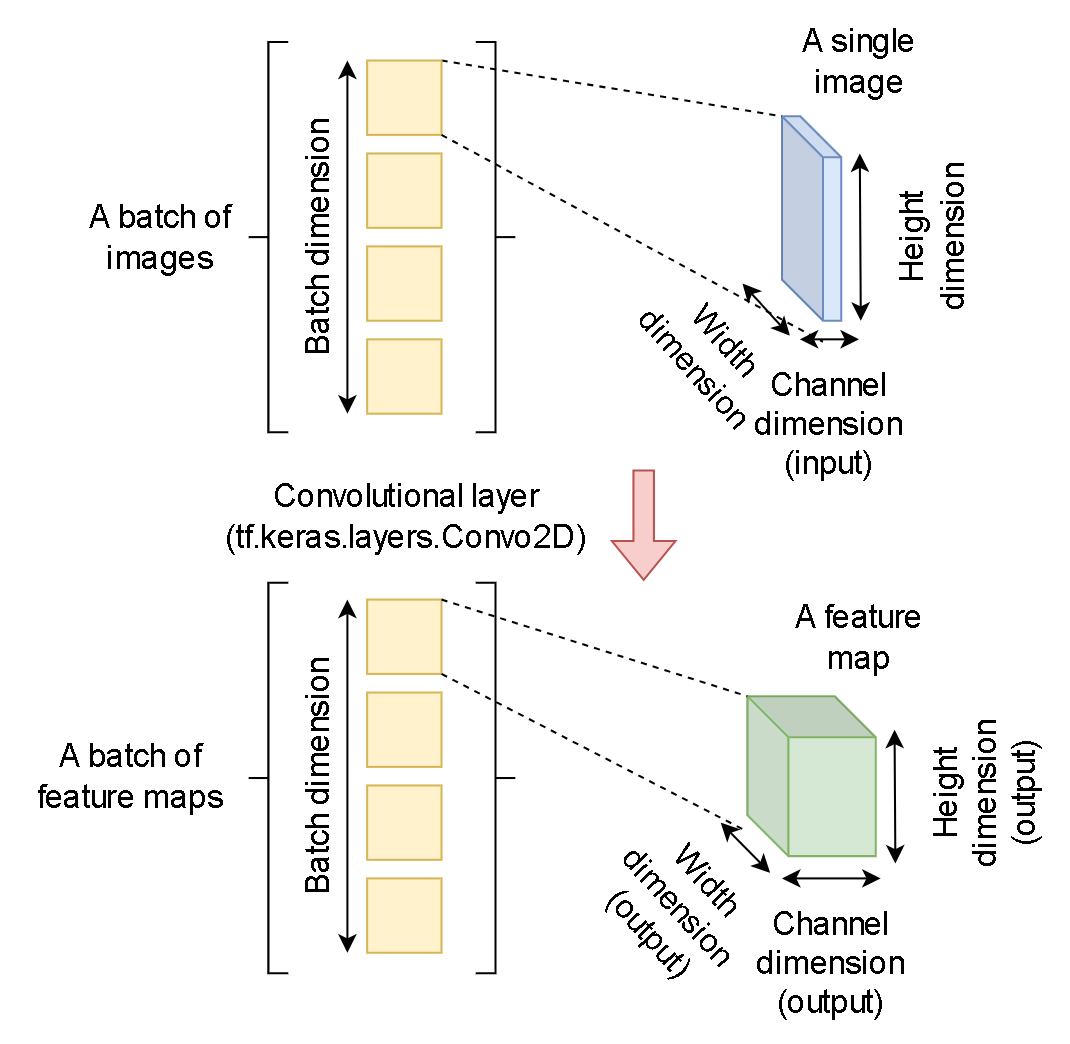

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

K.clear_session()

lenet_like_model = Sequential([
    # 1st convolutional layer
    Conv2D(
        filters=16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu',
        input_shape=(image_size,image_size,n_channels)
    ), # in 28x28 / out 24x24
    # 1st max pooling layer
    MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'), # in 24x24 / out 12x12
    # 2nd convolutional layer
    Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'), # in 12x12 / out 8x8
    # 2nd max pooling layer
    MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'), # in 8x8 / out 4x4
    # 3rd convolutional layer
    Conv2D(filters=120, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'), # in 4x4 / out 1x1
    # flatten the output of the last layer to suit a fully connected layer
    Flatten(),
    # First dense (fully connected) layer
    Dense(84, activation='relu'),
    # Final prediction layer
    Dense(n_classes, activation='softmax')
])

# Compile with a loss and an optimizer
lenet_like_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary
lenet_like_model.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,686 (190.18 KB)

 Trainable params: 48,686 (190.18 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
lenet_like_model.fit(train_images, train_labels, validation_split=0.2, epochs=5)

Epoch 1/5


2024-09-23 17:11:46.579207: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


  19/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1957 - loss: 9.0160  

2024-09-23 17:11:47.818129: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24473600 exceeds 10% of free system memory.
2024-09-23 17:11:47.818193: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24473600 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7328 - loss: 0.9729 - val_accuracy: 0.8455 - val_loss: 0.4341
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8562 - loss: 0.3906 - val_accuracy: 0.8642 - val_loss: 0.3744
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8743 - loss: 0.3443 - val_accuracy: 0.8744 - val_loss: 0.3528
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8823 - loss: 0.3124 - val_accuracy: 0.8628 - val_loss: 0.3831
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8897 - loss: 0.2968 - val_accuracy: 0.8827 - val_loss: 0.3350


In [44]:
lenet_like_model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8818 - loss: 0.3656


[0.34973594546318054, 0.8798999786376953]

In [45]:
test_predictions = lenet_like_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


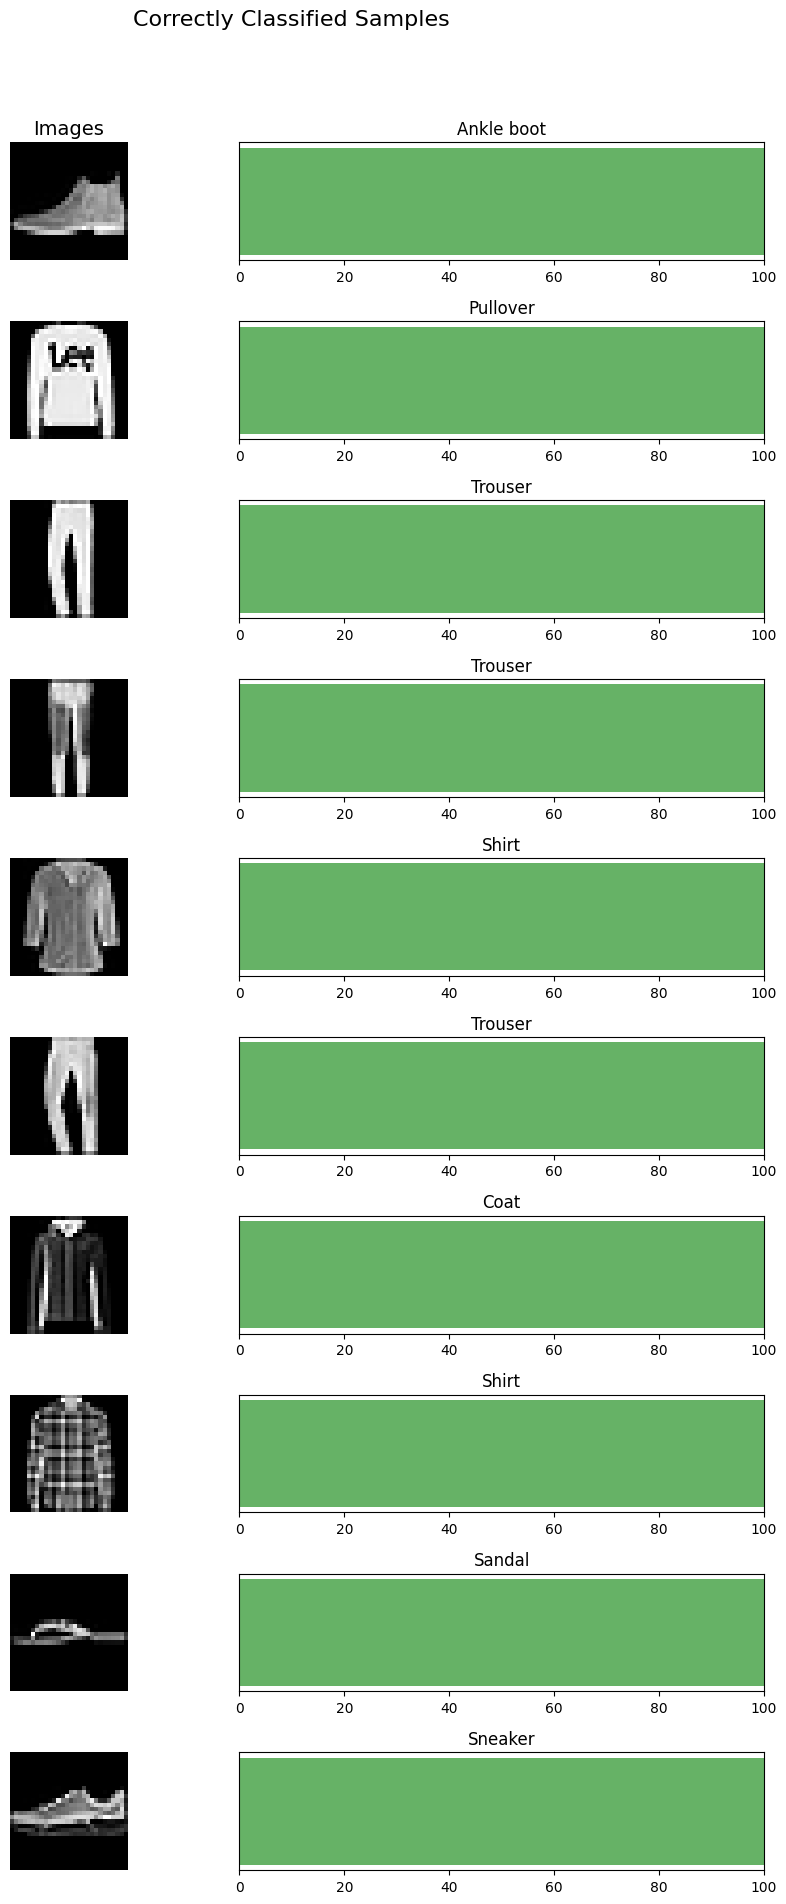

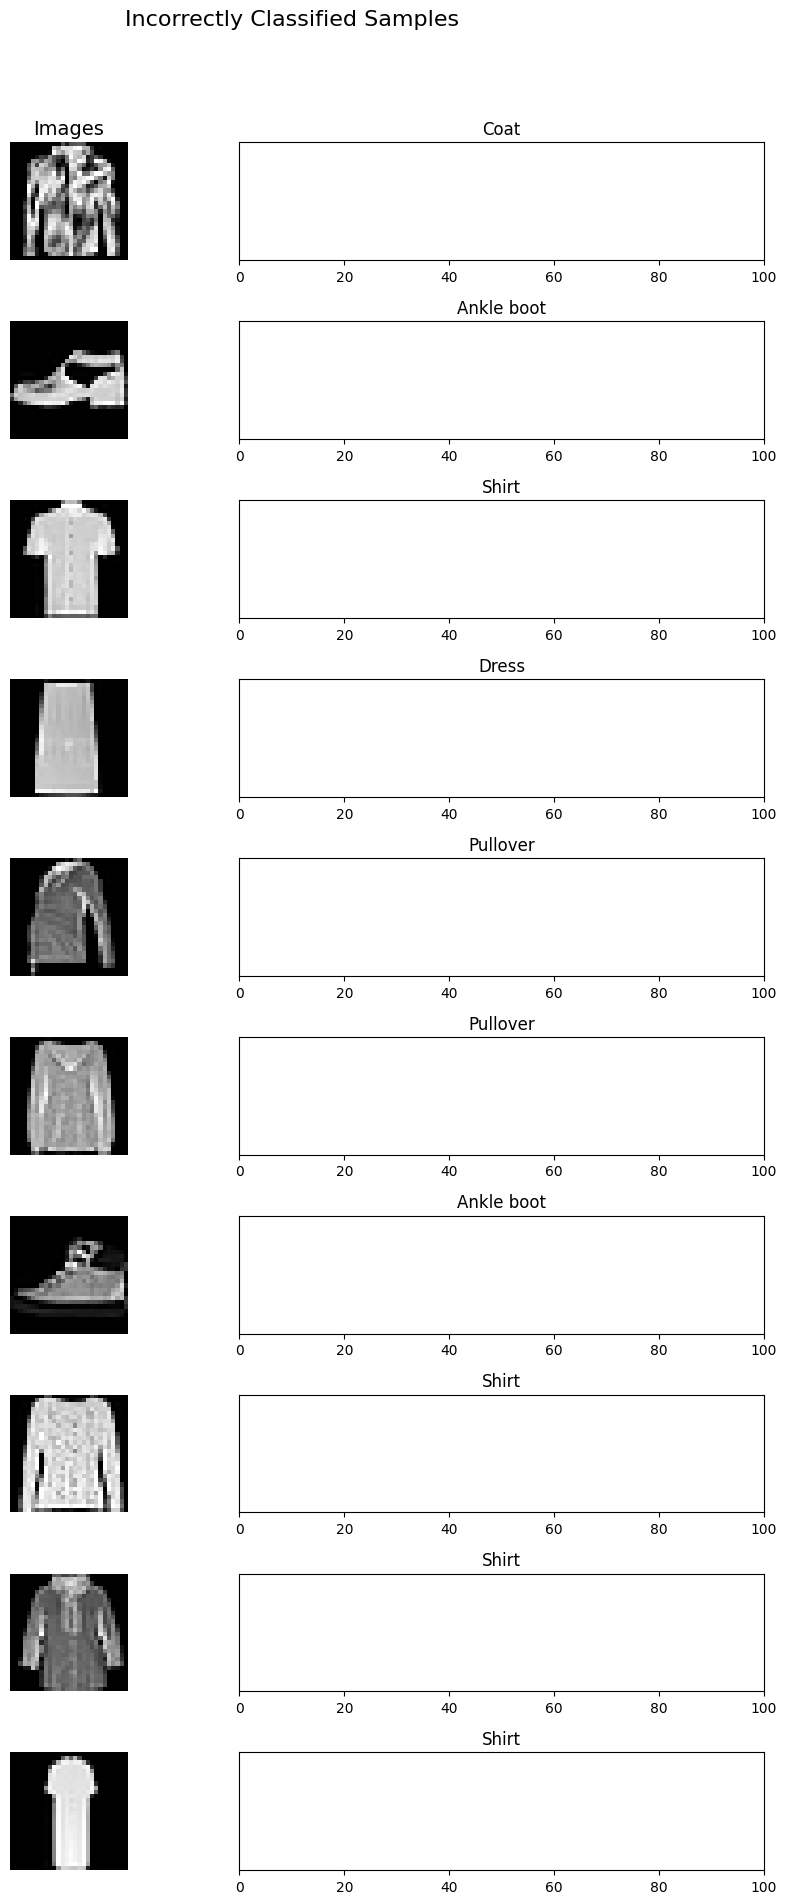

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_labels and test_predictions are available
predicted_labels = np.argmax(test_predictions, axis=1)

# Identify correctly and incorrectly classified samples
correct_indices = np.where(test_labels == predicted_labels)[0]
incorrect_indices = np.where(test_labels != predicted_labels)[0]

# Function to visualize samples
def visualize_samples(indices, title, label_map):
    n_images = min(len(indices), 10)  # Limit to 10 images for display
    fig, axes = plt.subplots(n_images, 2, figsize=(10, n_images * 2))  # Adjust figure size

    # Title for the entire section
    fig.suptitle(title, fontsize=16)

    # Images section
    axes[0, 0].set_title('Images', fontsize=14)
    for i, idx in enumerate(indices[:n_images]):
        axes[i, 0].imshow(test_images[idx], cmap='gray', extent=[0, 85, 0, 85])  # Set extent to 85x85
        axes[i, 0].axis('off')

    # Predictions section
    axes[0, 1].set_title('Softmax Predictions', fontsize=14)
    for i, idx in enumerate(indices[:n_images]):
        true_label = test_labels[idx]
        accuracy = 100 if true_label == predicted_labels[idx] else 0
        
        # Horizontal bar for accuracy
        axes[i, 1].barh(0, accuracy, color='green' if accuracy == 100 else 'red', alpha=0.6)
        axes[i, 1].set_yticks([])
        axes[i, 1].set_xlim(0, 100)
        axes[i, 1].set_title(label_map[true_label])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize correctly classified samples
visualize_samples(correct_indices, "Correctly Classified Samples", label_map)

# Visualize incorrectly classified samples
visualize_samples(incorrect_indices, "Incorrectly Classified Samples", label_map)
